<a href="https://colab.research.google.com/github/PascalReich/SimplyCooking/blob/main/simplycooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download


1.   Kaggle api setup (optional)
1.   Download the data from kaggle
1.   Extract data to csv

Runtime: ~2m



In [10]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [11]:
! kaggle datasets download paultimothymooney/recipenlg

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/recipenlg
License(s): other
... resuming from 581959680 bytes (92333502 bytes left) ...
 98% 633M/643M [00:00<00:00, 120MB/s] 
100% 643M/643M [00:00<00:00, 109MB/s]


In [12]:
! unzip recipenlg.zip

Archive:  recipenlg.zip
  inflating: RecipeNLG_code/README.md  
  inflating: RecipeNLG_code/eval/evaluation.ipynb  
  inflating: RecipeNLG_code/generation/README.md  
  inflating: RecipeNLG_code/generation/SAMPLE.md  
  inflating: RecipeNLG_code/generation/dataset2text.ipynb  
  inflating: RecipeNLG_code/generation/preparation.py  
  inflating: RecipeNLG_code/generation/run_generation.py  
  inflating: RecipeNLG_code/generation/run_lm_finetuning.py  
  inflating: RecipeNLG_code/generation/run_lm_finetuning_new.py  
  inflating: RecipeNLG_code/generation/run_lm_finetuning_tpu.py  
  inflating: RecipeNLG_code/generation/tokenization.py  
  inflating: RecipeNLG_code/ner/Language2_0.ipynb  
  inflating: RecipeNLG_code/ner/NER.ipynb  
  inflating: RecipeNLG_code/ner/model/meta.json  
  inflating: RecipeNLG_code/ner/model/ner/cfg  
  inflating: RecipeNLG_code/ner/model/ner/model  
  inflating: RecipeNLG_code/ner/model/ner/moves  
  inflating: RecipeNLG_code/ner/model/tokenizer  
  inflating:

# Train

In [13]:
# train_model.py

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import pickle
import re
import json



In [14]:



# Predefined units and common words to remove
units = [
    "teaspoon", "tablespoon", "cup", "ounce", "oz", "pound", "lb", "box", "can",
    "jar", "package", "clove", "pinch", "dash", "stick", "slice", "bunch", "bag",
    "c", "oz", "cans", "pkg", "container"
]
common_words = ["fresh", "dried", "large", "small", "medium", "chopped", "sliced", "minced", "ground", "whole", "inch", "thick", "round"]

# Function to clean and standardize ingredient names
def preprocess_ingredient(ingredient):
    ingredient = ingredient.lower()
    ingredient = re.sub(r'\d+', '', ingredient)  # Remove digits
    ingredient = re.sub(r'[^\w\s]', '', ingredient)  # Remove punctuation
    tokens = ingredient.split(" ")
    cleaned_tokens = [token for token in tokens if token not in units + common_words]
    cleaned_ingredient = ' '.join(cleaned_tokens)
    # print(cleaned_ingredient)
    return cleaned_ingredient.strip()


### Load the dataset and remove unnecessary data

In [15]:
recipes_df = pd.read_csv('RecipeNLG_dataset.csv')

recipes_df = recipes_df.drop(columns=["directions", "link", "source", "ingredients"])
recipes_df = recipes_df.rename(columns={"Unnamed: 0": "id", "NER": "ingredients"})

recipes_df.head(10)



,id,title,ingredients
0,0,No-Bake Nut Cookies,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
5,5,Cheeseburger Potato Soup,"[""baking potatoes"", ""extra lean ground beef"", ..."
6,6,Rhubarb Coffee Cake,"[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flou..."
7,7,Scalloped Corn,"[""cream-style corn"", ""whole kernel corn"", ""cra..."
8,8,Nolan'S Pepper Steak,"[""tomatoes"", ""water"", ""onions"", ""Worcestershir..."
9,9,Millionaire Pie,"[""pineapple"", ""condensed milk"", ""lemons"", ""pec..."


### Turn the ingredient list from a json list into a real python list

In [16]:
recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: json.loads(x))
recipes_df.head(10)

,id,title,ingredients
0,0,No-Bake Nut Cookies,"[brown sugar, milk, vanilla, nuts, butter, bit..."
1,1,Jewell Ball'S Chicken,"[beef, chicken breasts, cream of mushroom soup..."
2,2,Creamy Corn,"[frozen corn, cream cheese, butter, garlic pow..."
3,3,Chicken Funny,"[chicken, chicken gravy, cream of mushroom sou..."
4,4,Reeses Cups(Candy),"[peanut butter, graham cracker crumbs, butter,..."
5,5,Cheeseburger Potato Soup,"[baking potatoes, extra lean ground beef, butt..."
6,6,Rhubarb Coffee Cake,"[sugar, butter, egg, buttermilk, flour, salt, ..."
7,7,Scalloped Corn,"[cream-style corn, whole kernel corn, crackers..."
8,8,Nolan'S Pepper Steak,"[tomatoes, water, onions, Worcestershire sauce..."
9,9,Millionaire Pie,"[pineapple, condensed milk, lemons, pecans, gr..."


### Train Word2Vec model on cleaned ingredients
Runtime: ~4m

In [17]:
ingredient_lists = recipes_df['ingredients'].tolist()
word2vec = Word2Vec(sentences=ingredient_lists, vector_size=100, window=5, min_count=1, workers=4)




### Generate vectors
Runtime: ~2m

In [18]:
# Function to create recipe vectors by averaging ingredient vectors
def get_recipe_vector(ingredients):
    ingredient_vectors = [word2vec.wv[ingredient] for ingredient in ingredients if ingredient in word2vec.wv]
    return sum(ingredient_vectors) / len(ingredient_vectors) if ingredient_vectors else None

# Apply function to create recipe vectors
recipes_df['recipe_vector'] = recipes_df['ingredients'].apply(get_recipe_vector)

# Filter out recipes without vectors and convert vectors to a numpy array
recipe_vectors = np.array([vec for vec in recipes_df['recipe_vector'] if vec is not None])



### Cluster with K-means and save!

In [19]:
# Cluster recipes using K-means
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
recipes_df = recipes_df.dropna(subset=['recipe_vector'])  # Ensure no None values before clustering
recipes_df['cluster'] = kmeans.fit_predict(recipe_vectors)

# Save the models and data to disk
with open('word2vec.model', 'wb') as f:
    pickle.dump(word2vec, f)
with open('kmeans.model', 'wb') as f:
    pickle.dump(kmeans, f)
recipes_df[['id', 'title', 'recipe_vector', 'cluster']].to_pickle('recipes_with_vectors.pkl')

print("Training complete. Models saved.")

Training complete. Models saved.


# Check

### Example: list some things in a cluster

In [20]:
recipes_df[recipes_df['cluster'] == 0]['title'].head(10)

,title
9,Millionaire Pie
14,Pink Stuff(Frozen Dessert)
15,Fresh Strawberry Pie
18,Strawberry Whatever
21,Chocolate Frango Mints
30,Punch Bowl Fruit Salad
32,Cherry Pizza
38,Pear-Lime Salad
39,Watermelon Rind Pickles
62,Phylis' Pineapple-Banana Salad


### Visualize Embeddings via dimensionality reduction

<ipython-input-21-8f75a91ddbd6>:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data, x='dim1', y='dim2', style='cluster', palette='viridis', s=50, alpha=0.7)


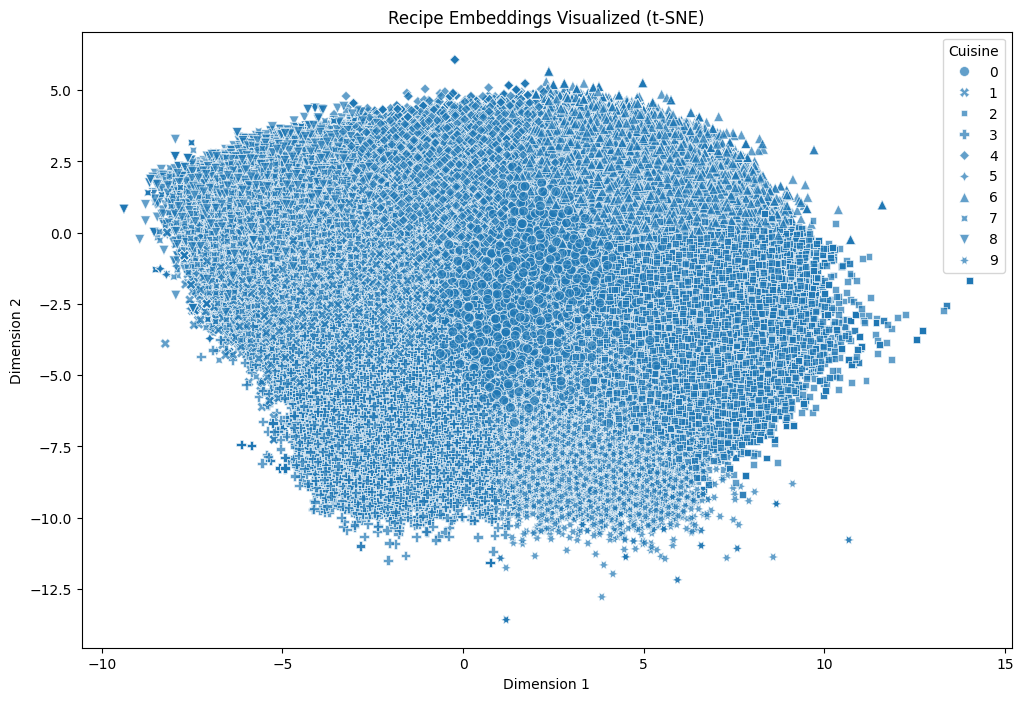

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load recipe vectors and metadata
data = pd.read_pickle('recipes_with_vectors.pkl')
data = data.dropna(subset=['recipe_vector'])  # Drop recipes without vectors
recipe_vectors = np.vstack(data['recipe_vector'].values)  # Stack into 2D array

# Choose dimensionality reduction technique: PCA or t-SNE
def reduce_dimensions(vectors, method='pca', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced = reducer.fit_transform(vectors)
    return reduced

# Reduce recipe vectors to 2D
reduced_vectors = reduce_dimensions(recipe_vectors)#, method='tsne')

# Add reduced dimensions to data for plotting
data['dim1'] = reduced_vectors[:, 0]
data['dim2'] = reduced_vectors[:, 1]

# Plot the embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='dim1', y='dim2', style='cluster', palette='viridis', s=50, alpha=0.7)
plt.title("Recipe Embeddings Visualized (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='Cuisine')
plt.show()


# Test via CLI


In [22]:
import pandas as pd
import numpy as np
import pickle
from scipy.spatial.distance import cosine

# Load the trained models and data
with open('word2vec.model', 'rb') as f:
    word2vec = pickle.load(f)
with open('kmeans.model', 'rb') as f:
    kmeans = pickle.load(f)
recipes_df = pd.read_pickle('recipes_with_vectors.pkl')

# Function to create a recipe vector from user ingredients
def get_user_vector(ingredients):
    ingredient_vectors = [word2vec.wv[ingredient] for ingredient in ingredients if ingredient in word2vec.wv]
    return sum(ingredient_vectors) / len(ingredient_vectors) if ingredient_vectors else None

# Function to recommend recipes based on ingredient similarity
def recommend_recipes_by_ingredients(user_ingredients, num_recommendations=5):
    user_vector = get_user_vector(user_ingredients)
    if user_vector is None:
        print("No matching ingredients found in the model.")
        return []

    # Calculate cosine similarity between user vector and recipe vectors
    recipes_df['similarity'] = recipes_df['recipe_vector'].apply(
        lambda x: 1 - cosine(user_vector, x) if x is not None else 0
    )
    recommendations = recipes_df.sort_values(by='similarity', ascending=False).head(num_recommendations)

    return recommendations[['title', 'similarity', 'cluster']]

# Function to recommend recipes based on a favorite recipe ID
def recommend_recipes_by_recipe_id(recipe_id, num_recommendations=5):
    # Find the recipe vector for the given recipe_id
    recipe = recipes_df.loc[recipes_df['id'] == recipe_id]
    if recipe.empty or recipe['recipe_vector'].iloc[0] is None:
        print(f"Recipe ID {recipe_id} not found or has no vector.")
        return []

    # Use the recipe's vector to find similar recipes
    target_vector = recipe['recipe_vector'].iloc[0]
    recipes_df['similarity'] = recipes_df['recipe_vector'].apply(
        lambda x: 1 - cosine(target_vector, x) if x is not None else 0
    )
    # Exclude the original recipe from recommendations
    recommendations = recipes_df[recipes_df['id'] != recipe_id].sort_values(by='similarity', ascending=False).head(num_recommendations)

    return recommendations[['title', 'similarity', 'cluster']]

# Interactive function for user input
def interactive_recommendation():
    print("Welcome to the Recipe Recommendation System!")

    while True:
        print("\nWould you like to find similar recipes based on:")
        print("1. Favorite ingredients")
        print("2. A favorite recipe ID")
        print("Enter 'q' to quit.")

        choice = input("Please enter your choice (1 or 2): ").strip()

        if choice == '1':
            ingredients_input = input("Enter your favorite ingredients, separated by commas: ").strip()
            user_ingredients = [ingredient.strip().lower() for ingredient in ingredients_input.split(',')]
            num_recommendations = int(input("How many recommendations would you like to see? "))

            recommendations = recommend_recipes_by_ingredients(user_ingredients, num_recommendations)
            if not len(recommendations):
                print("No recommendations found.")
            else:
                print("\nRecommended Recipes:")
                for idx, row in recommendations.iterrows():
                    print(f"Recipe Title: {row['title']}, Similarity: {row['similarity']:.2f}, Cluster: {row['cluster']}")

        elif choice == '2':
            recipe_id = int(input("Enter the favorite recipe ID: "))
            num_recommendations = int(input("How many recommendations would you like to see? "))

            recommendations = recommend_recipes_by_recipe_id(recipe_id, num_recommendations)
            if not len(recommendations):
                print("No recommendations found.")
            else:
                print("\nRecommended Recipes:")
                for idx, row in recommendations.iterrows():
                    print(f"Recipe Title: {row['title']}, Similarity: {row['similarity']:.2f}, Cluster: {row['cluster']}")

        elif choice.lower() == 'q':
            print("Thank you for using the Recipe Recommendation System. Goodbye!")
            break
        else:
            print("Invalid choice, please try again.")

interactive_recommendation()


In [23]:
!pip install gradio

# Test with the frontend by Gradio

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import pickle
from scipy.spatial.distance import cosine

# Load the trained models and data
with open('word2vec.model', 'rb') as f:
    word2vec = pickle.load(f)
with open('kmeans.model', 'rb') as f:
    kmeans = pickle.load(f)
recipes_df = pd.read_pickle('recipes_with_vectors.pkl')

# Function to create a recipe vector from user ingredients
def get_user_vector(ingredients):
    ingredient_vectors = [word2vec.wv[ingredient] for ingredient in ingredients if ingredient in word2vec.wv]
    return sum(ingredient_vectors) / len(ingredient_vectors) if ingredient_vectors else None

# Function to recommend recipes based on ingredient similarity
def recommend_recipes_by_ingredients(user_ingredients, num_recommendations=5):
    user_vector = get_user_vector(user_ingredients)
    if user_vector is None:
        return "No matching ingredients found in the model."

    # Calculate cosine similarity between user vector and recipe vectors
    recipes_df['similarity'] = recipes_df['recipe_vector'].apply(
        lambda x: 1 - cosine(user_vector, x) if x is not None else 0
    )
    recommendations = recipes_df.sort_values(by='similarity', ascending=False).head(num_recommendations)
    return recommendations[['title', 'similarity', 'cluster']].to_dict(orient='records')

# Function to recommend recipes based on a favorite recipe ID
def recommend_recipes_by_recipe_id(recipe_id, num_recommendations=5):
    # Find the recipe vector for the given recipe_id
    recipe = recipes_df.loc[recipes_df['id'] == recipe_id]
    if recipe.empty or recipe['recipe_vector'].iloc[0] is None:
        return f"Recipe ID {recipe_id} not found or has no vector."

    # Use the recipe's vector to find similar recipes
    target_vector = recipe['recipe_vector'].iloc[0]
    recipes_df['similarity'] = recipes_df['recipe_vector'].apply(
        lambda x: 1 - cosine(target_vector, x) if x is not None else 0
    )
    recommendations = recipes_df[recipes_df['id'] != recipe_id].sort_values(by='similarity', ascending=False).head(num_recommendations)
    return recommendations[['title', 'similarity', 'cluster']].to_dict(orient='records')

# Gradio function for ingredient-based recommendations
def gradio_recommend_ingredients(ingredients, num_recommendations):
    ingredients_list = [ingredient.strip().lower() for ingredient in ingredients.split(",")]
    recommendations = recommend_recipes_by_ingredients(ingredients_list, num_recommendations)
    if isinstance(recommendations, str):
        return recommendations
    return pd.DataFrame(recommendations)

# Gradio function for recipe ID-based recommendations
def gradio_recommend_recipe_id(recipe_id, num_recommendations):
    try:
        recipe_id = int(recipe_id)
    except ValueError:
        return "Invalid Recipe ID. Please enter a number."
    recommendations = recommend_recipes_by_recipe_id(recipe_id, num_recommendations)
    if isinstance(recommendations, str):
        return recommendations
    return pd.DataFrame(recommendations)

def gradio_recommend_cluster(cluster, num_recommendations):
    return pd.DataFrame(recipes_df[recipes_df['cluster'] == int(cluster)]['title'].sample(num_recommendations))

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Recipe Recommendation System")
    gr.Markdown("### Find recipes by entering ingredients or a recipe ID")

    # Ingredient-based recommendation
    with gr.Tab("Recommend by Ingredients"):
        ingredients_input = gr.Textbox(label="Enter ingredients (comma-separated)")
        num_recommendations_ingredients = gr.Slider(label="Number of recommendations", minimum=1, maximum=100, value=5)
        recommend_ingredients_button = gr.Button("Get Recommendations")
        output_ingredients = gr.Dataframe(label="Recommended Recipes")

        recommend_ingredients_button.click(
            gradio_recommend_ingredients,
            inputs=[ingredients_input, num_recommendations_ingredients],
            outputs=output_ingredients
        )

    # Recipe ID-based recommendation
    with gr.Tab("Recommend by Recipe ID"):
        recipe_id_input = gr.Textbox(label="Enter Recipe ID")
        num_recommendations_id = gr.Slider(label="Number of recommendations", minimum=1, maximum=100, value=5)
        recommend_id_button = gr.Button("Get Recommendations")
        output_id = gr.Dataframe(label="Recommended Recipes")

        recommend_id_button.click(
            gradio_recommend_recipe_id,
            inputs=[recipe_id_input, num_recommendations_id],
            outputs=output_id
        )


    # Cluster-based recommendation
    with gr.Tab("Recommend by Cluster"):
        cluster_id_input = gr.Dropdown(list(range(0, 10)), label="Cluster")
        num_recommendations_id = gr.Slider(label="Number of recommendations", minimum=0, maximum=100, value=5)
        recommend_id_button = gr.Button("Get Recommendations")
        output_id = gr.Dataframe(label="Recommended Recipes")

        recommend_id_button.click(
            gradio_recommend_cluster,
            inputs=[cluster_id_input, num_recommendations_id],
            outputs=output_id
        )

demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d96be4e08139419c99.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
